# Dungeons and Dragons Character Backstory Machine Learning Model

Data from [janelleshane dnd-characters](https://github.com/janelleshane/DnD-characters/blob/master/DnD_characters_May2018.txt)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import pickle

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
char_df = pd.read_csv('data/dnd_characters.txt')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20908 entries, 0 to 20907
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   character_name     20886 non-null  object
 1   character_species  20886 non-null  object
 2   character_class    20881 non-null  object
dtypes: object(3)
memory usage: 490.2+ KB


In [5]:
char_df.head()

,character_name,character_species,character_class
0,Haley,Human,Thief
1,Korshakk,Half-Orc,Fighter
2,Aoi,Half-orc,Paladin
3,Lexina,Fey,Bard
4,Gilshar,dwarf,warpriest


In [6]:
char_df = char_df.dropna()

In [7]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20875 entries, 0 to 20907
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   character_name     20875 non-null  object
 1   character_species  20875 non-null  object
 2   character_class    20875 non-null  object
dtypes: object(3)
memory usage: 652.3+ KB


In [8]:
char_df.character_species.unique()

array(['Human', 'Half-Orc', 'Half-orc', ..., 'Rabbit-man',
       'Gutter Duergar', 'Half dwarf'], dtype=object)

In [9]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()

# Verify the change
char_df['character_species'].value_counts()

character_species
human             5633
elf               1499
half-elf          1315
dwarf             1273
halfling          1198
                  ... 
hellbred             1
orog                 1
lesser aasimar       1
half-genasi          1
half dwarf           1
Name: count, Length: 1239, dtype: int64

In [10]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [11]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


In [12]:
# Your list of species
species = char_df.character_species.unique()

# Allowed species names
allowed_species = [
    'Aasimar', 'Dragonborn', 'Dwarf', 'Elf', 'Gnome',
    'Goliath', 'Halfling', 'Human', 'Orc', 'Tiefling'
]

# Define a function to clean up the species names and keep multiple valid species
def clean_species(species_string):
    # Make the species string lowercase for comparison
    species_string_lower = species_string.lower()

    # List to collect valid species found in the string
    found_species = []

    # Check if any allowed species appears in the string
    for allowed_speci in allowed_species:
        # Convert the allowed species to lowercase for comparison
        if allowed_speci.lower() in species_string_lower:
            found_species.append(allowed_speci)  # Add the valid species to the list

    # If any valid species were found, return them joined by slashes
    if found_species:
        return '/'.join(found_species)
    return None  # If no valid species is found, return None

In [13]:
# Apply the cleaning function to the 'character_class' column
char_df['cleaned_species'] = char_df['character_species'].apply(clean_species)

In [14]:
char_df['cleaned_species'].value_counts(dropna=False)

cleaned_species
Human                5863
Elf                  4416
None                 3432
Dwarf                1398
Halfling             1276
Orc                  1184
Tiefling             1071
Gnome                 962
Dragonborn            726
Aasimar               302
Goliath               209
Elf/Orc                 7
Elf/Human               6
Dwarf/Elf               3
Gnome/Orc               2
Human/Orc               2
Elf/Tiefling            1
Aasimar/Human           1
Dragonborn/Elf          1
Elf/Gnome               1
Dwarf/Halfling          1
Dwarf/Orc               1
Dragonborn/Human        1
Dragonborn/Orc          1
Dwarf/Human             1
Gnome/Human/Orc         1
Elf/Goliath             1
Aasimar/Tiefling        1
Dwarf/Elf/Human         1
Halfling/Tiefling       1
Gnome/Human             1
Human/Tiefling          1
Name: count, dtype: int64

In [15]:
char_df.character_class.unique()

array(['thief', 'fighter', 'paladin', ..., 'tie-fighter pilot',
       'used to be a druid...', 'archivist bard'], dtype=object)

In [16]:
# Your list of classes
classes = char_df.character_class.unique()

# Allowed class names
allowed_classes = [
    'Barbarian', 'Bard', 'Cleric', 'Druid', 'Fighter', 'Monk', 
    'Paladin', 'Ranger', 'Rogue', 'Sorceror', 'Warlock', 'Wizard'
]

# Define a function to clean up the class names and keep multiple valid classes
def clean_class(class_string):
    # Make the class string lowercase for comparison
    class_string_lower = class_string.lower()

    # List to collect valid classes found in the string
    found_classes = []

    # Check if any allowed class appears in the string
    for allowed_class in allowed_classes:
        # Convert the allowed class to lowercase for comparison
        if allowed_class.lower() in class_string_lower:
            found_classes.append(allowed_class)  # Add the valid class to the list

    # If any valid classes were found, return them joined by slashes
    if found_classes:
        return '/'.join(found_classes)
    return None  # If no valid class is found, return None


In [17]:
# Apply the cleaning function to the 'character_class' column
char_df['cleaned_class'] = char_df['character_class'].apply(clean_class)

In [18]:
char_df['cleaned_class'].value_counts(dropna=False)

cleaned_class
None                              4093
Rogue                             1984
Bard                              1868
Fighter                           1862
Cleric                            1838
                                  ... 
Cleric/Fighter/Ranger/Wizard         1
Fighter/Rogue/Warlock                1
Monk/Ranger                          1
Barbarian/Fighter/Ranger/Rogue       1
Sorceror/Warlock                     1
Name: count, Length: 92, dtype: int64

In [19]:
# Count rows where both 'cleaned_species' and 'cleaned_class' are None
none_count = char_df[(char_df['cleaned_species'].isna()) & (char_df['cleaned_class'].isna())].shape[0]
none_count

1086

In [20]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20875 entries, 0 to 20907
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   character_name     20875 non-null  object
 1   character_species  20875 non-null  object
 2   character_class    20875 non-null  object
 3   cleaned_species    17443 non-null  object
 4   cleaned_class      16782 non-null  object
dtypes: object(5)
memory usage: 978.5+ KB


In [21]:
# Drop rows where either 'cleaned_class' or 'cleaned_species' is None
char_df = char_df.dropna(subset=['cleaned_class', 'cleaned_species'])

In [22]:

def remove_low_count_rows(df, column, threshold=5):
    # Count occurrences of each value in the column
    counts = df[column].value_counts()
    
    # Filter the DataFrame to keep rows where the count is >= threshold
    filtered_df = df[df[column].isin(counts[counts >= threshold].index)]
    return filtered_df


In [23]:

char_df = remove_low_count_rows(char_df, 'cleaned_species')
char_df = remove_low_count_rows(char_df, 'cleaned_class')

In [24]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14329 entries, 1 to 20907
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   character_name     14329 non-null  object
 1   character_species  14329 non-null  object
 2   character_class    14329 non-null  object
 3   cleaned_species    14329 non-null  object
 4   cleaned_class      14329 non-null  object
dtypes: object(5)
memory usage: 671.7+ KB


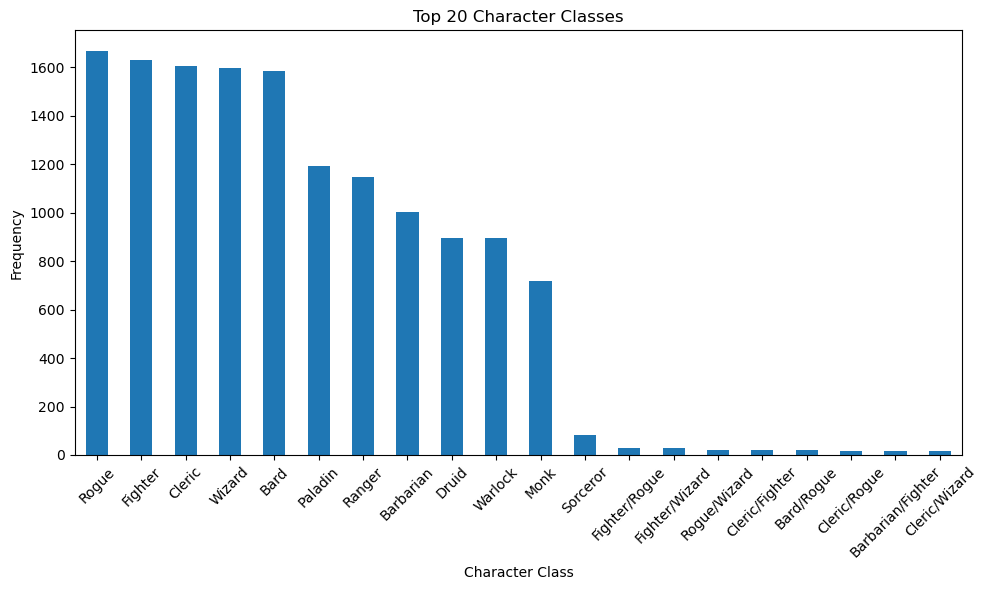

In [25]:
top_20_classes = char_df.cleaned_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [26]:
char_df.head(10)

,character_name,character_species,character_class,cleaned_species,cleaned_class
1,korshakk,half-orc,fighter,Orc,Fighter
2,aoi,half-orc,paladin,Orc,Paladin
5,nathandriel kelemaneril,elf,cleric,Elf,Cleric
8,bubbles,gnome,druid,Gnome,Druid
9,slash,half-elf,rogue,Elf,Rogue
10,vallys termina,elf,wizard,Elf,Wizard
11,ven,human,paladin,Human,Paladin
12,linxakasendalor surina,dragonborn,paladin,Dragonborn,Paladin
14,kestrelsong,half-orc,druid,Orc,Druid
16,tempus,tiefling,paladin,Tiefling,Paladin


____

## Model Training

___

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Separate features and target
X = char_df[['character_species', 'character_class']]
y = char_df['character_name']

# One-Hot Encoding for the features (species, class)
onehot_encoder = OneHotEncoder()
X_encoded = onehot_encoder.fit_transform(X)

# Label Encoding for the target (character_name)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [28]:
# def evaluate_models(X_train, X_test, y_train, y_test):
#     # Define the models in a dictionary
#     models = {
#         # 'Logistic Regression': LogisticRegression(max_iter=1000),
#         'Random Forest': RandomForestClassifier(),
#         'Decision Tree': DecisionTreeClassifier()
#         # 'K-Nearest Neighbors': KNeighborsClassifier(),
#         # 'SVM': SVC()
#     }

#     # Create a dictionary to store the pipelines
#     pipelines = {}
    
#     # For each model, create a pipeline and fit it
#     for name, model in models.items():
#         pipeline = Pipeline([('model', model)])  # Simple pipeline, model-only for now
#         pipeline.fit(X_train, y_train)
#         pipelines[name] = pipeline
    
#     # Evaluate each model
#     results = {}
#     for name, pipeline in pipelines.items():
#         y_pred = pipeline.predict(X_test)
#         accuracy = accuracy_score(y_test, y_pred)
#         results[name] = accuracy
#         print(f"{name}: Accuracy = {accuracy * 100:.2f}%")
    
#     # Return the models and their accuracy
#     return results

# results = evaluate_models(X_train, X_test, y_train, y_test)

In [29]:
def tune_decision_tree(X_train, X_test, y_train, y_test):
    # Define the Decision Tree model
    model = DecisionTreeClassifier(random_state=42)
    
    # Define hyperparameters for tuning
    param_grid = {
        'max_depth': [None, 10, 20, 30, 40],            # Maximum depth of the tree
        'min_samples_split': [2, 10, 20],               # Minimum number of samples to split
        'min_samples_leaf': [1, 5, 10],                 # Minimum number of samples per leaf node
        'criterion': ['gini', 'entropy']                # Splitting criterion
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    
    # Fit the model using grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best Decision Tree accuracy: {accuracy * 100:.2f}%")
    print(f"Best hyperparameters: {grid_search.best_params_}")
    
    # Return the best model and the accuracy
    return best_model, accuracy

In [30]:
best_tree_model, best_accuracy = tune_decision_tree(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Decision Tree accuracy: 0.63%
Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


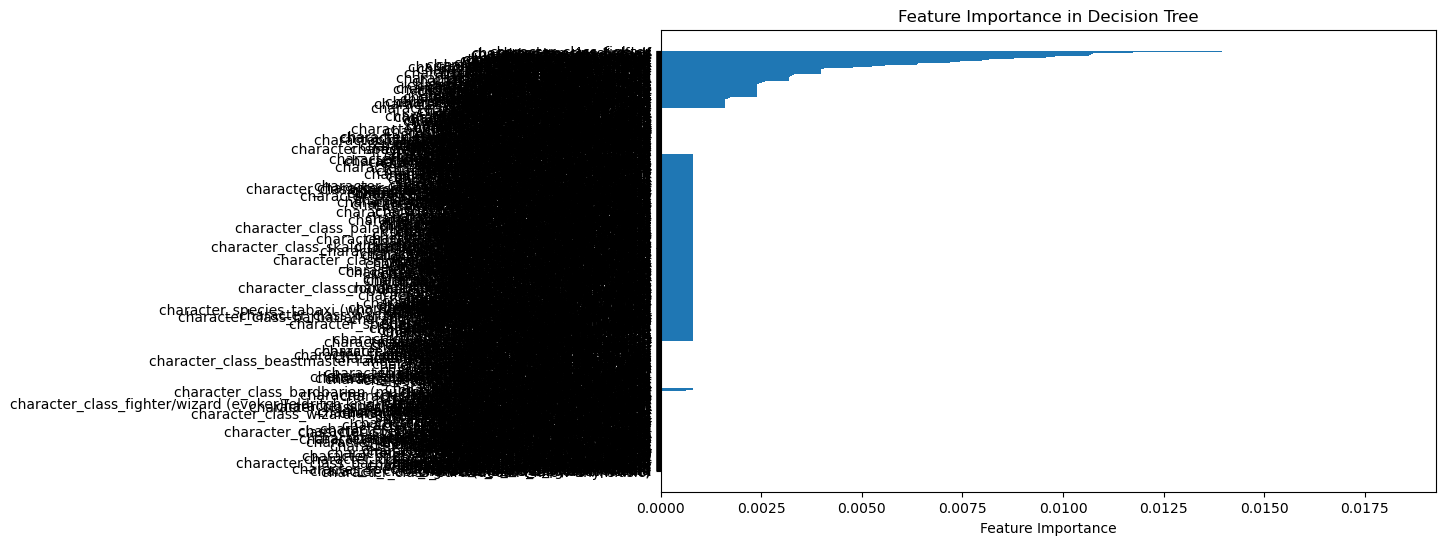

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the best model
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance in Decision Tree')
    plt.gca().invert_yaxis()
    plt.show()

# Example usage: assuming X_encoded is the feature matrix and 'best_tree_model' is your trained Decision Tree
plot_feature_importance(best_tree_model, onehot_encoder.get_feature_names_out())